In [ ]:
# Step 1: Install dependencies:

dependencies = ['pandas-gbq', 'wordcloud', 'yake', 'rake_nltk', 'textstat', 'keybert[spacy]', 'flatbuffers', 'spacy']

for dependency in dependencies:
    !pip install {dependency}


In [30]:
# Step 1: Import libraries:

# General libraries
import os
import warnings

# Data processing and visualization libraries
import pandas as pd
import numpy as np 
import string
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go

# Natural language processing libraries
import re
import nltk
import spacy
from collections import Counter
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
spacy.cli.download("en_core_web_sm")



# Keyword extraction libraries
import yake
from keybert import KeyBERT
from rake_nltk import Rake

# Text summarization libraries
from sentence_transformers import SentenceTransformer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import pipeline


# Google BigQuery libraries
from google.oauth2 import service_account
from pandas.io import gbq

# Sentiment analysis libraries
import textstat
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Vectorization libraries
from operator import itemgetter
from operator import attrgetter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [31]:
#Importing Zero shot Classification Model

classifier = pipeline("zero-shot-classification", device = 0)

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [32]:
# Step 3:  Importing Data from Kaggle:
dataset = pd.read_csv("dominos_pizza_review.csv")

In [33]:
#Step 4: Clean the dataset:

# Remove any rows with missing or null values in the 'text' column
dataset = dataset.dropna(subset=['text'])

# Drop any rows where the cleaned text is empty
dataset = dataset[dataset['text'].str.len() > 0]

#Drop Duplicates:
dataset.drop_duplicates(subset='text', inplace=True)

def is_valid_review(text):
    # Remove all non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # If the review contains fewer than 10 words, it's not valid
    if len(text.split()) < 10:
        return False
    
    # If the review contains any URLs, it's not valid
    if re.search(r'http\S+', text):
        return False
    
    return True

dataset = dataset[dataset['text'].apply(is_valid_review)]


# convert to lowercase
dataset['text'] = dataset['text'].str.lower()

# remove punctuation
dataset['text'] = dataset['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Reset Index:
dataset.reset_index(drop=True, inplace=True)


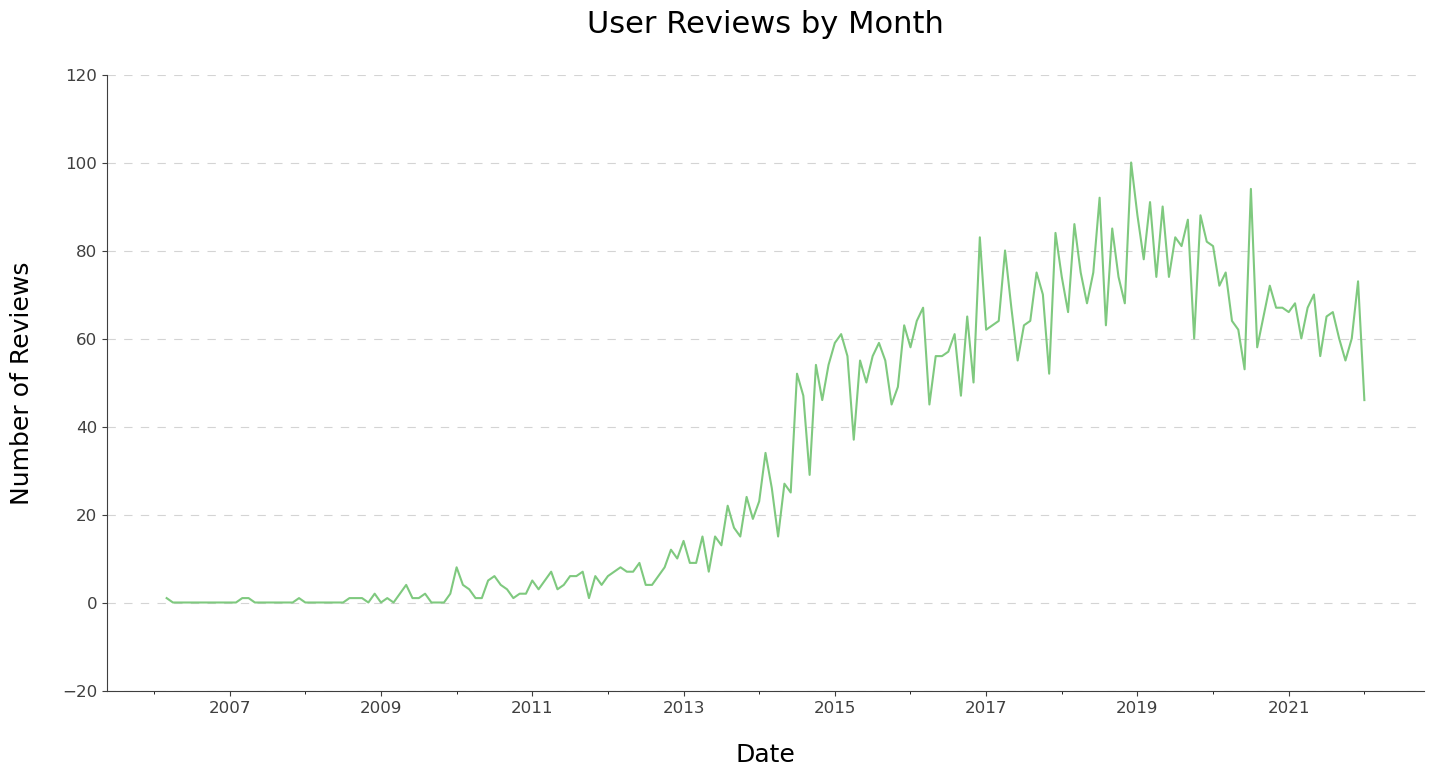

In [9]:
#Step 5: Exploratory Data Analysis:

#If you would like to explore no-code solution for the following data visualization, check out the attached Google Looker Studio.

#Distribution of User Reviews by Month:


# Convert the date column to datetime format
dataset['date'] = pd.to_datetime(dataset['date'])

# Group the data by month and count the number of reviews in each month
reviews_by_month = dataset.groupby(pd.Grouper(key='date', freq='M')).size()

# Plot the timeseries of reviews by month
plt.style.use('default')
fig, ax = plt.subplots(figsize=(17, 8))
reviews_by_month.plot(ax=ax,  colormap='Accent')
ax.set_title('User Reviews by Month\n', horizontalalignment='center', fontstyle='normal', fontsize=22, fontfamily='sans-serif')
ax.set_xlabel('Date', horizontalalignment='center', fontstyle='normal', fontsize=18, fontfamily='sans-serif', labelpad=20)
ax.set_ylabel('Number of Reviews', horizontalalignment='center', fontstyle='normal', fontsize=18, fontfamily='sans-serif', labelpad=20)
ax.tick_params(labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#3f3f3f')
ax.spines['left'].set_color('#3f3f3f')
ax.tick_params(axis='x', colors='#3f3f3f')
ax.tick_params(axis='y', colors='#3f3f3f')
plt.style.use('classic')
plt.xticks(rotation=0, horizontalalignment='center', fontsize=12)
plt.yticks(rotation=0, horizontalalignment='right', fontsize=12)
ax.autoscale(enable=True, axis='both', tight=False)
plt.grid(axis='y', color='#d4d4d4', linestyle='--')
plt.show()




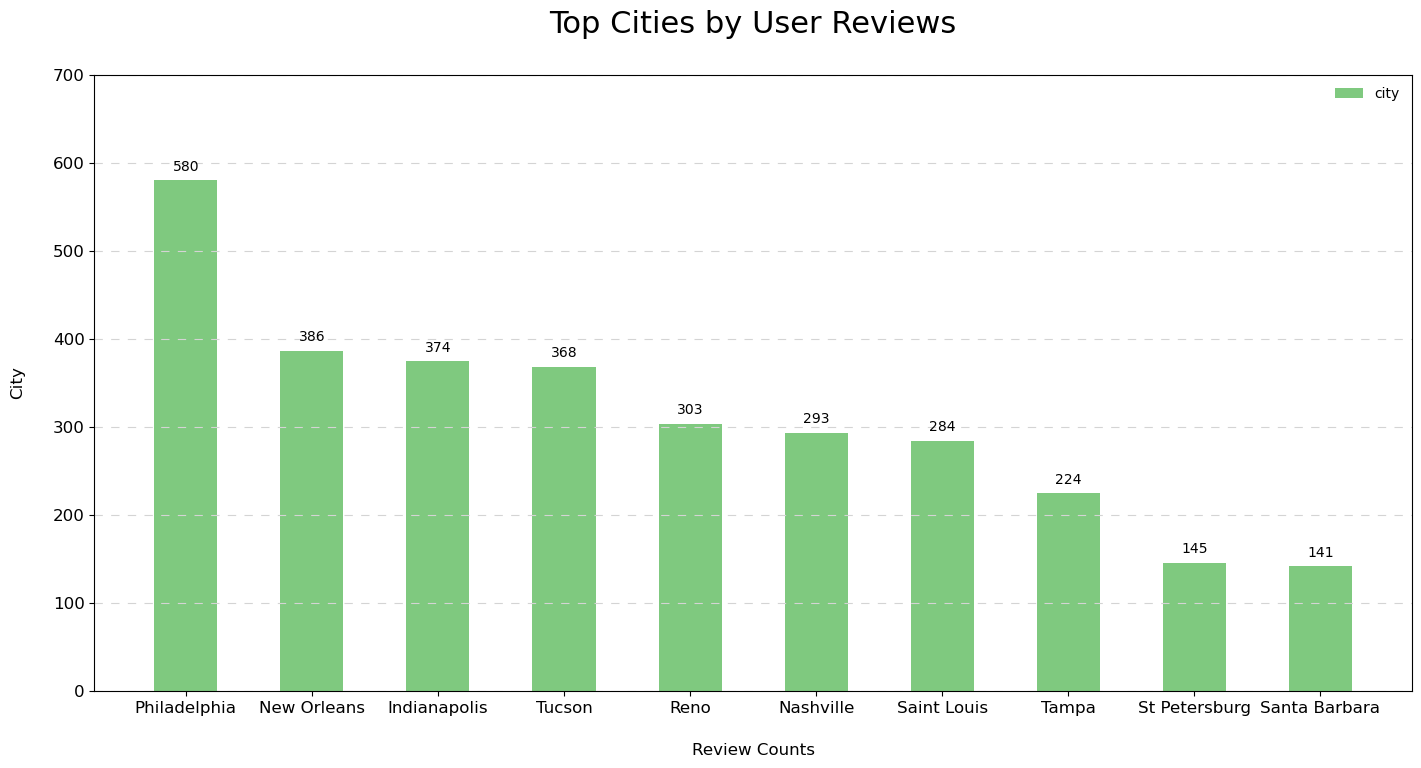

In [10]:
#Step 5.2: Distribution of User Reviews by Cities:
plt.style.use('default')
ax = dataset['city'].value_counts()[:10].plot.bar(
    title='Top Cities by User Reviews',  
    figsize=(17, 8),  
    colormap='Accent',  
    fontsize=15,  
    xlabel='Review Counts', 
    ylabel='City',  
    legend=True,  
    table=False,  
    grid=False,  
    subplots=False,  
    stacked=False,  
    linestyle='-',  
)

# Add the digit labels on top of the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    
# set up the x and y labels
ax.set_xlabel('Review Counts', horizontalalignment='center', fontstyle='normal', fontsize='large', fontfamily='sans-serif', labelpad=20)
ax.set_ylabel('City', horizontalalignment='center', fontstyle='normal', fontsize='large', fontfamily='sans-serif', labelpad=20)

# set up the title, legends and theme
ax.set_title('Top Cities by User Reviews\n', horizontalalignment='center', fontstyle='normal', fontsize=22, fontfamily='sans-serif')
plt.legend(loc='upper right', fontsize="medium", frameon=False) 
plt.xticks(rotation=0, horizontalalignment='center', fontsize=12)
plt.yticks(rotation=0, horizontalalignment='right', fontsize=12)
plt.style.use('classic')
ax.autoscale(enable=True, axis='both', tight=False)
plt.grid(axis='y', color='#d4d4d4', linestyle='--')
plt.show()

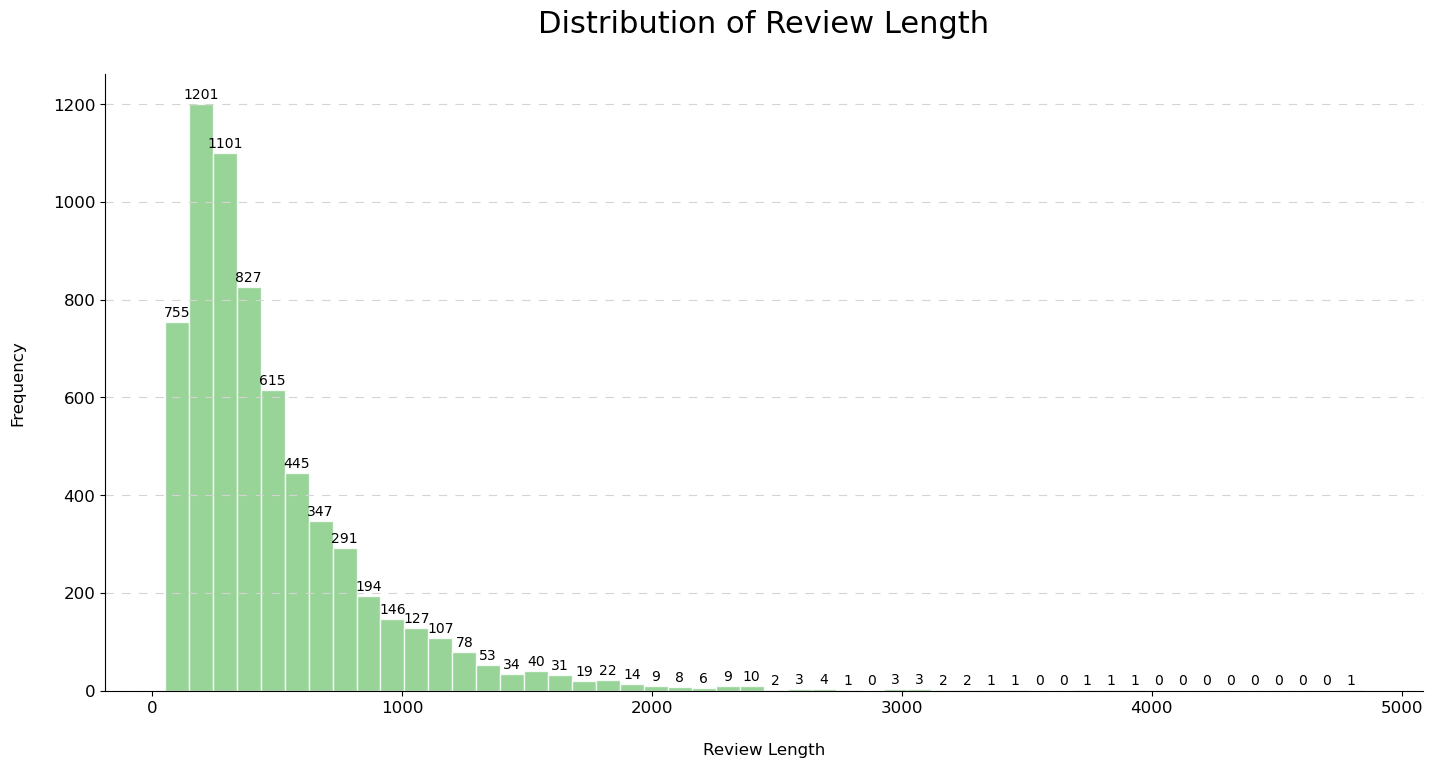

In [21]:
#Step 5.3: Validate distribution of review length:

# Create a new column in the dataframe containing the length of each review
dataset['review_length'] = dataset['text'].apply(len)

# Set up the figure and axis
plt.style.use('default')
fig, ax = plt.subplots(figsize=(17, 8))
ax.set_title('Distribution of Review Length\n', horizontalalignment='center', fontstyle='normal', fontsize=22, fontfamily='sans-serif')
ax.set_xlabel('Review Length', horizontalalignment='center', fontstyle='normal', fontsize='large', fontfamily='sans-serif', labelpad=20)
ax.set_ylabel('Frequency', horizontalalignment='center', fontstyle='normal', fontsize='large', fontfamily='sans-serif', labelpad=20)

# Plot a histogram of review length distribution
ax.hist(dataset['review_length'], bins=50, color='#7fc97f', edgecolor='white', alpha=0.8)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the background color to white
ax.set_facecolor('White')

# Add the digit labels on top of the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, int(height), ha='center', va='bottom', fontfamily='sans-serif', fontsize=10)

# Set the x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the style
plt.style.use('classic')
#ax.autoscale(enable=True, axis='both', tight=False)
plt.grid(axis='y', color='#d4d4d4', linestyle='--')
plt.show()

             
# Show the plot
plt.show()


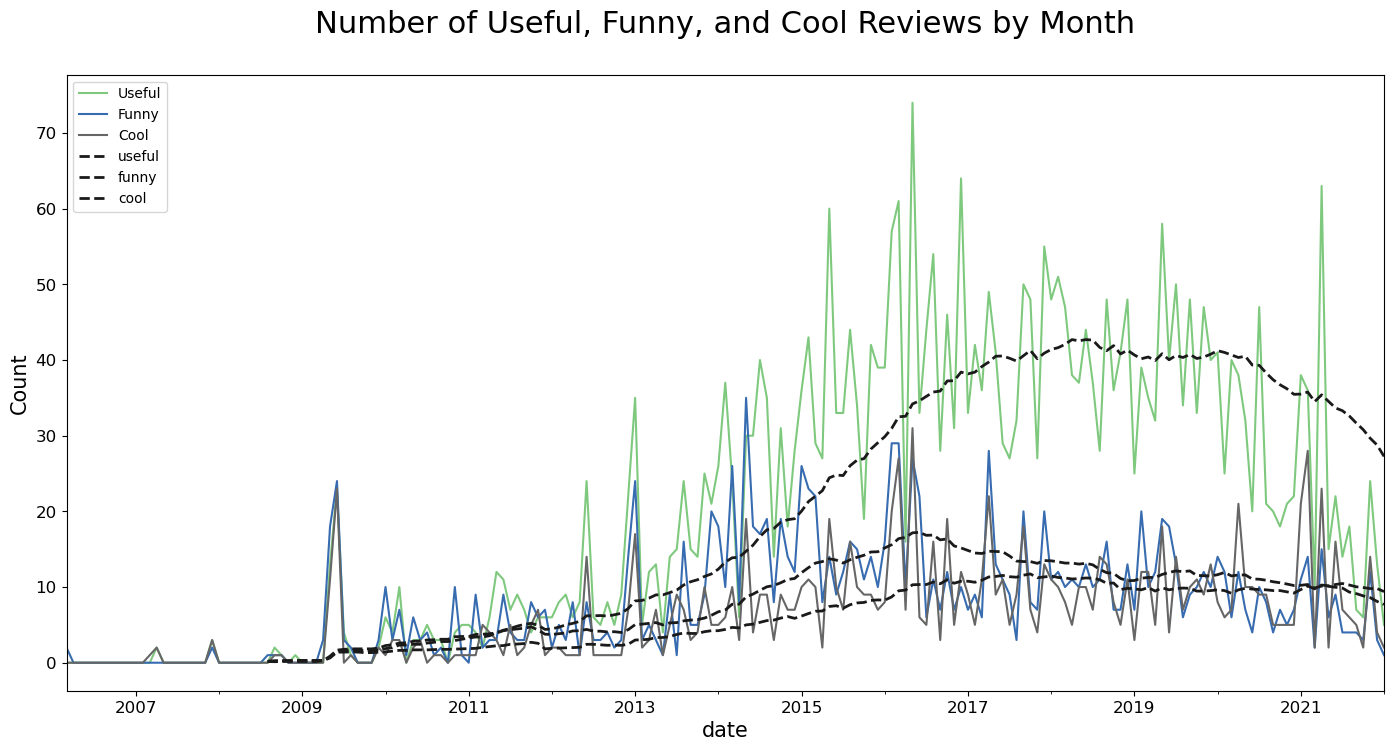

In [18]:
#Step 5.4: Number of Useful, Funny and Cool Reviews by Month:

# create a copy of the original dataset and set the date column as the index
df = dataset.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# group by month and sum the useful, funny, and cool columns
monthly_counts = df.groupby(pd.Grouper(freq='M')).sum()[['useful', 'funny', 'cool']]

# plot a multi-line graph of useful, funny, and cool reviews by month with a 30-day moving average
plt.style.use('default')
ax = monthly_counts.plot(figsize=(17, 8), colormap='Accent', fontsize=15, linestyle='-')
ax.set_title('Number of Useful, Funny, and Cool Reviews by Month\n', fontsize=22)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.legend(['Useful', 'Funny', 'Cool'], fontsize=15, loc='upper left')

# add a 30-day moving average line to the graph
rolling_mean = monthly_counts.rolling(window=30).mean()
rolling_mean.plot(ax=ax, color='k', linestyle='--', linewidth=2)

# set the style of the graph
plt.style.use('classic')
plt.xticks(rotation=0, horizontalalignment='center', fontsize=12)
plt.yticks(rotation=0, horizontalalignment='right', fontsize=12)

ax.autoscale(enable=False, axis='both', tight=False)
plt.show()

Text(0.5, 1.0, 'Correlation Matrix of Numeric Variables\n')

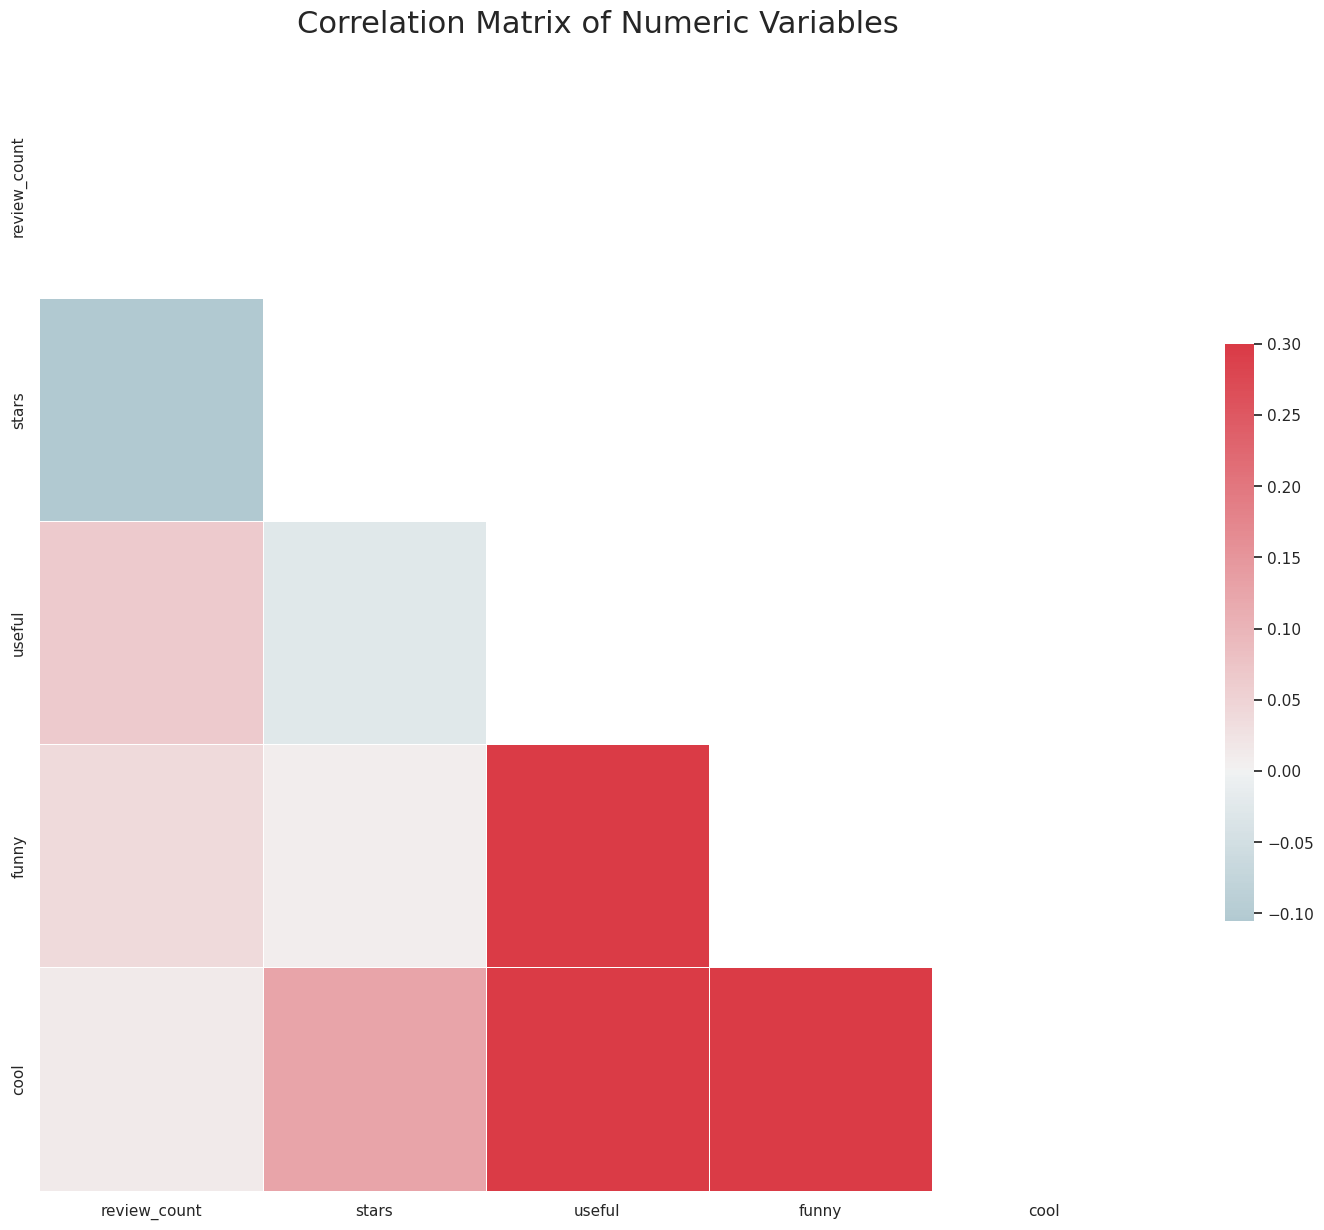

In [30]:
#Step 5.5: Correlation Matrix of Numeric Variables:

plt.style.use('default')

# Select the numeric columns from the dataset
numeric_cols = ['review_count', 'stars', 'useful', 'funny', 'cool']

# Create a correlation matrix
sns.set(style="white")
corr_matrix = dataset[numeric_cols].corr()

# Generate a mask for the upper triangle:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add the title
ax.set_title('Correlation Matrix of Numeric Variables\n', horizontalalignment='center', fontstyle='normal', fontsize=22, fontfamily='sans-serif')





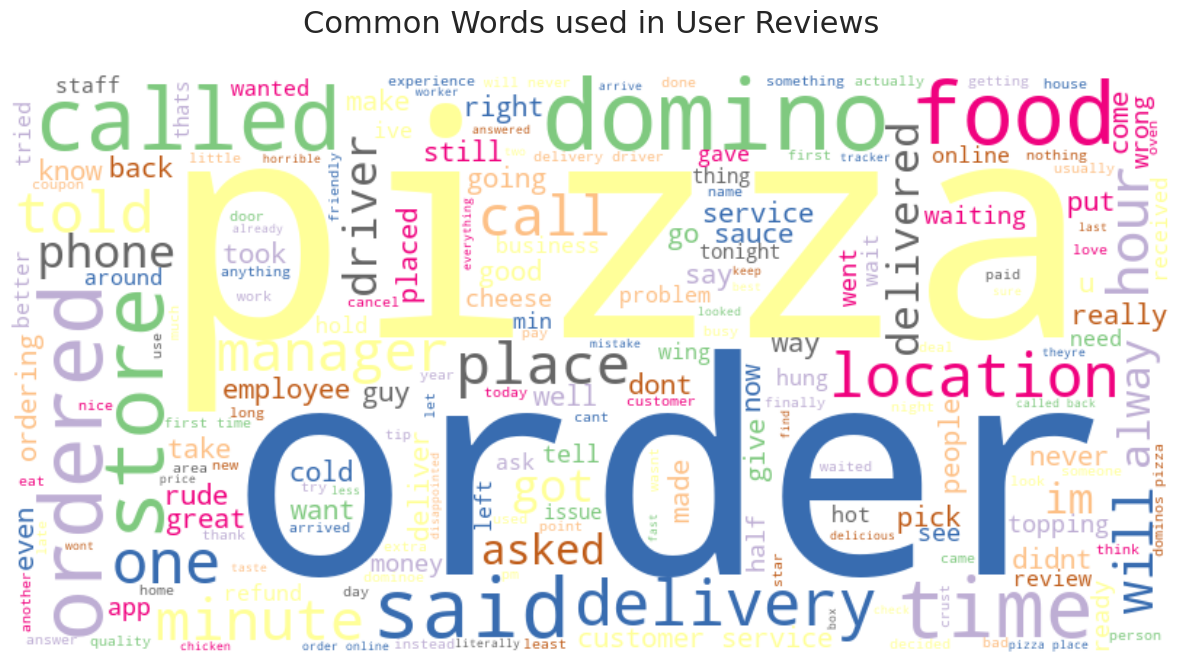

In [29]:
#Step 5.6: Common words used in Reviews: 

#Combine all text into a single string
all_text = ' '.join(dataset['text'].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Accent', max_words=200).generate(all_text)

# Display the word cloud
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words used in User Reviews\n', fontsize=22, fontstyle='normal', fontfamily='sans-serif')
plt.show()

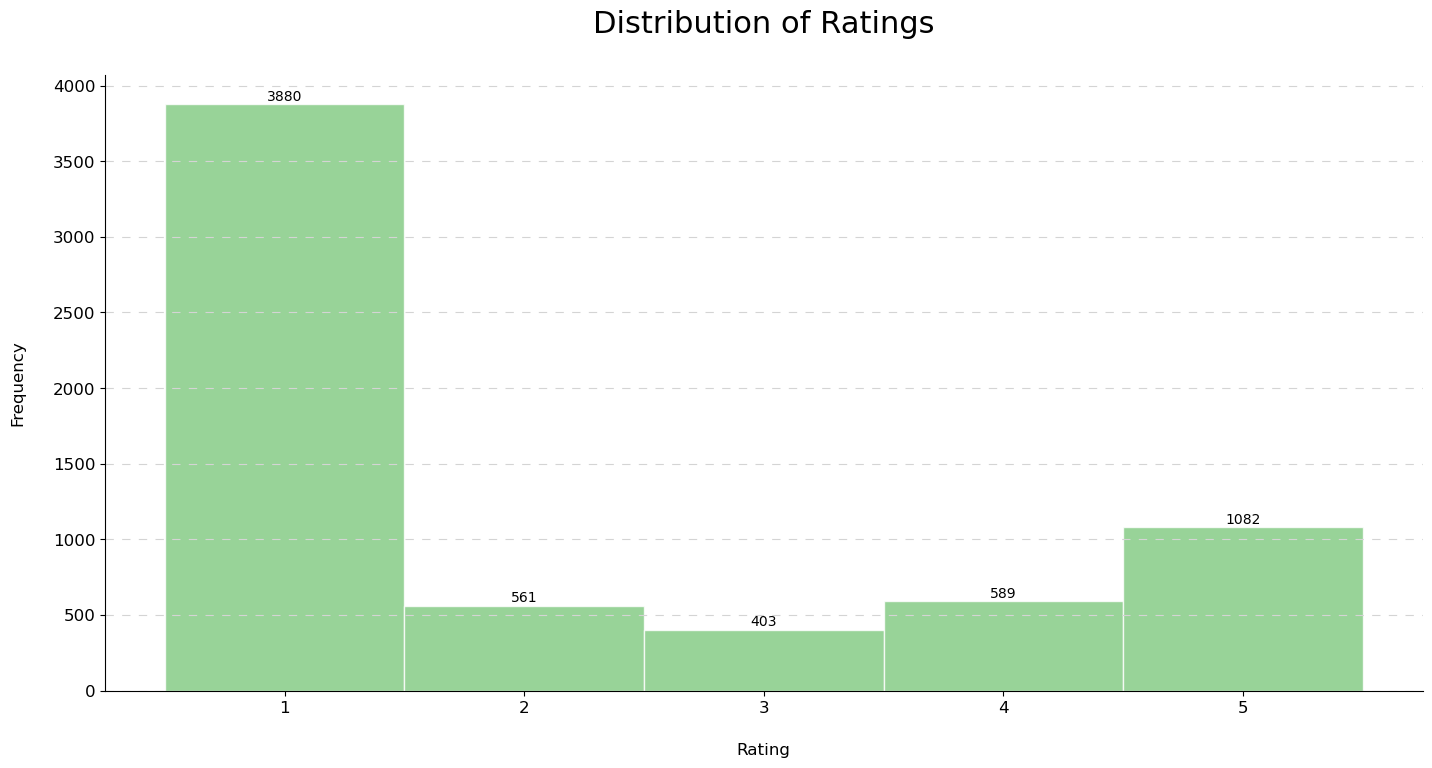

In [31]:
# Step 5.7: Validate distribution of ratings

plt.style.use('default')
fig, ax = plt.subplots(figsize=(17, 8))
ax.set_title('Distribution of Ratings\n', horizontalalignment='center', fontstyle='normal', fontsize=22, fontfamily='sans-serif')
ax.set_xlabel('Rating', horizontalalignment='center', fontstyle='normal', fontsize='large', fontfamily='sans-serif', labelpad=20)
ax.set_ylabel('Frequency', horizontalalignment='center', fontstyle='normal', fontsize='large', fontfamily='sans-serif', labelpad=20)

# Plot a histogram of rating distribution
ax.hist(dataset['stars'], bins=5, range=[0.5, 5.5], color='#7fc97f', edgecolor='white', alpha=0.8)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the background color to white
ax.set_facecolor('White')

# Add the digit labels on top of the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, int(height), ha='center', va='bottom', fontfamily='sans-serif', fontsize=10)

# Set the x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the style
plt.style.use('classic')
#ax.autoscale(enable=True, axis='both', tight=False)
plt.grid(axis='y', color='#d4d4d4', linestyle='--')
plt.show()


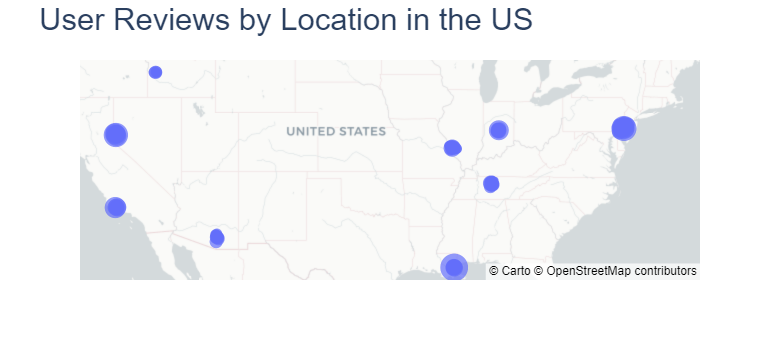

In [15]:
# Step 5.8: Plot user reviews on a map

# Group the reviews by latitude and longitude, and count the number of reviews in each group
location_reviews = dataset.groupby(['latitude', 'longitude']).size().reset_index(name='count')

# Set up the map figure
fig = px.scatter_mapbox(location_reviews, lat='latitude', lon='longitude', size='count', hover_name='count', zoom=3, center={'lat': 37.0902, 'lon': -95.7129}, mapbox_style='carto-positron')

# Set the title and font
fig.update_layout(title='User Reviews by Location in the US', font=dict(family='sans-serif', size=22))

# Show the figure
fig.show()

In [ ]:
#Step 6: Auto Text Classification:

# Topic Modelling:
# extract text data from the dataset
sequence = list(dataset["text"])

# define the candidate labels/topics for classification
candidate_labels = ["Customer service", "Delivery experience", "Pizza Quality", "Value for money", "Online ordering experience", "Atmosphere", "Dietary restrictions", "Location"]

# apply the HuggingFace Zero Shot Classification method to classify the text data into candidate topics/labels
text_classification = classifier(sequence, candidate_labels)

# create a pandas dataframe to store the text classification results
text_classification = pd.DataFrame(text_classification)


In [ ]:
# Select the first label:
text_classification["labels"] = text_classification["labels"].astype(str)

# Split the comma-separated labels into separate columns
interim = text_classification["labels"].str.split(',', expand = True)

select = [0]
interim = interim[select]

# Rename the columns and remove any quotes or brackets from the labels
interim = interim.rename(columns = {0: 'topic_clusters'})

interim["topic_clusters"] = interim["topic_clusters"].str.replace('[','')
interim["topic_clusters"] = interim["topic_clusters"].str.replace("'",'')

# Merge the raw dataset and the topic modelings
dataset = pd.merge(dataset, interim, left_index=True, right_index=True)

In [ ]:
# Get the precision_rate:
text_classification["topic_modelling_precision"] = text_classification["scores"].astype(str)

# Split the comma-separated labels into separate columns
interim = text_classification["topic_modelling_precision"].str.split(',', expand = True)

select = [0]
interim = interim[select]

# Rename the columns and remove any quotes or brackets from the labels
interim = interim.rename(columns = {0: 'topic_modelling_precision'})

interim["topic_modelling_precision"] = interim["topic_modelling_precision"].str.replace('[','')

# Merge the raw dataset and the topic modelings
dataset = pd.merge(dataset, interim, left_index=True, right_index=True)

In [ ]:
#Step 7: Sentiment Analysis:

# extract text data from the dataset
sequence = list(dataset["text"])

# Define the possible candidate labels for sentiment classification
candidate_labels = ["Positive", "Negative", "Neutral"]

# apply the HuggingFace Zero Shot Classification method to classify the text data into candidate topics/labels
text_classification = classifier(sequence, candidate_labels)

# create a pandas dataframe to store the text classification results
text_classification = pd.DataFrame(text_classification)




In [ ]:

# Select the first label:
text_classification["labels"] = text_classification["labels"].astype(str)

# Split the comma-separated labels into separate columns
interim = text_classification["labels"].str.split(',', expand = True)

select = [0]
interim = interim[select]
# Rename the columns and remove any quotes or brackets from the labels
interim = interim.rename(columns = {0: 'sentiment_analysis'})

interim["sentiment_analysis"] = interim["sentiment_analysis"].str.replace('[','')
interim["sentiment_analysis"] = interim["sentiment_analysis"].str.replace("'",'')

# Merge the raw dataset and the topic modelings
dataset = pd.merge(dataset, interim, left_index=True, right_index=True)

In [ ]:
# Get the sentiment analysis precision_rate:
text_classification["sa_precision"] = text_classification["scores"].astype(str)

# Split the comma-separated labels into separate columns
interim = text_classification["sa_precision"].str.split(',', expand = True)

select = [0]
interim = interim[select]

# Rename the columns and remove any quotes or brackets from the labels
interim = interim.rename(columns = {0: 'sa_precision'})

interim["sa_precision"] = interim["sa_precision"].str.replace('[','')

# Merge the raw dataset and the topic modelings
dataset = pd.merge(dataset, interim, left_index=True, right_index=True)

In [24]:
#Step 8: Keyword Extraction:

# Load the pre-trained NLP classifier
nlp = spacy.load("en_core_web_sm")

# Load the NLTK tokenizer
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Load a list of irrelevant words to remove
irrelevant_words = ["dominos" "pizza", "order", "delivery", "restaurant", "menu", "food", "service", "quality", "price", "place", "location"]

# Define a function to extract the top 5 most relevant keywords from a given text
def extract_keywords(text):
    # Use the NLTK tokenizer to split the text into sentences
    sentences = tokenizer.tokenize(text)
    
    # Create an empty Counter object to store the keyword counts
    keyword_counts = Counter()
    
    # Loop through each sentence in the text
    for sentence in sentences:
        # Use the spaCy model to parse the sentence
        doc = nlp(sentence)
        
        # Loop through each token in the sentence
        for token in doc:
            # Only consider certain parts of speech as keywords
            if token.pos_ in ["NOUN", "PROPN", "ADJ"]:
                # Ignore irrelevant words
                if token.text.lower() not in irrelevant_words:
                    # Increment the count for this keyword
                    keyword_counts[token.lemma_] += 1
    
    # Get the top 5 most frequent keywords
    top_keywords = keyword_counts.most_common(5)
    
    # Return a comma-separated string of the top keywords
    return ", ".join([keyword for keyword, count in top_keywords])


# Apply the extract_keywords function to the "text" column of the dataset
dataset["extracted_keywords"] = dataset["text"].apply(extract_keywords)

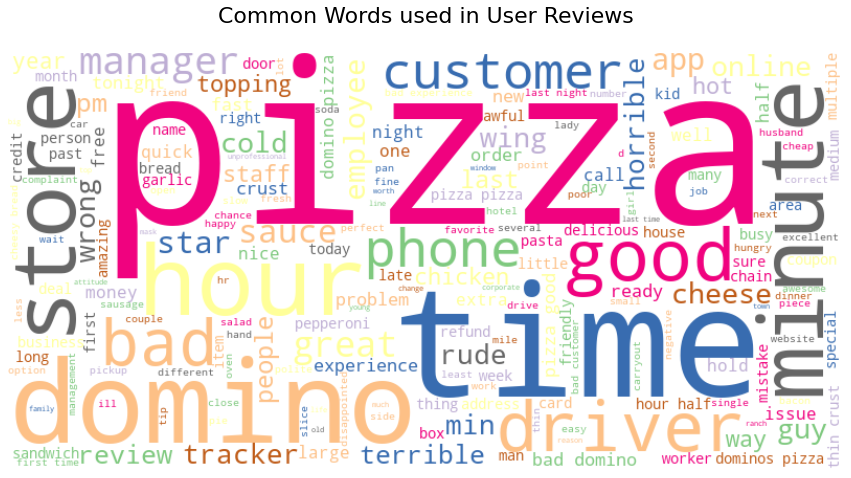

In [25]:
#Common keywords used in Reviews: Word Cloud

#Combine all text into a single string
all_text = ' '.join(dataset["extracted_keywords"].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Accent', max_words=200).generate(all_text)

# Display the word cloud
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words used in User Reviews\n', fontsize=22, fontstyle='normal', fontfamily='sans-serif')
plt.show()

In [49]:
#Step 9 : Summarization:

from transformers import pipeline
import warnings
import logging

# Set the logging level to only show errors and above
logging.basicConfig(level=logging.ERROR)

# Load the pre-trained summarization model
summarizer = pipeline("summarization")

# Define a function to summarize the text in each record
def summarize_text(text):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        summary = summarizer(text, max_length=60, min_length=30, do_sample=False)[0]['summary_text']
    return summary






No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [ ]:
# Split the dataset into smaller subsets based on business_id, review_id, and user_id
groups = dataset.groupby(["business_id", "review_id", "user_id"])

# Define an empty list to store the summarized text
summaries = []

# Loop over each group and apply the summarize_text function
for name, group in groups:
    summary = summarize_text(group["text"].iloc[0])
    summaries.append(summary)
    

In [ ]:
# Create a new DataFrame to store the summaries
summary_df = pd.DataFrame({
    "business_id": [name[0] for name in groups.groups.keys()],
    "review_id": [name[1] for name in groups.groups.keys()],
    "user_id": [name[2] for name in groups.groups.keys()],
    "summary": summaries
})

# Merge the summary_df with the original dataset on the "business_id", "review_id", and "user_id" columns
dataset = pd.merge(dataset, summary_df, on=["business_id", "review_id", "user_id"], how="left") 

In [ ]:
#Step 10: Publish the output:
dataset.to_csv('yelp_reviews_nlp.csv', index = False)